1. Data Preparation
We need to preprocess the images and masks to be suitable for training the model. Here's the code to prepare the data:

In [1]:
!pip install rasterio
!pip install tensorflow

In [2]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import os
import glob
import numpy as np
import cv2
import matplotlib.pyplot as plt
import rasterio
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.model_selection import train_test_split

# Set the paths to the images and labels directory
path_images = "/content/drive/MyDrive/images_train"
path_masks = "/content/drive/MyDrive/labels"

# Load the image and mask file paths
img_files = glob.glob(os.path.join(path_images, '*.tif'))
msk_files = glob.glob(os.path.join(path_masks, '*.png'))

img_files.sort()
msk_files.sort()


In [4]:
def load_images(image_files):
    images = []
    for file in image_files:
        with rasterio.open(file) as src:
            # Read all 12 bands and resize to (256, 256)
            img = src.read([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12])
            img = np.moveaxis(img, 0, -1)  # Move channels to the last dimension
            #img = cv2.resize(img, (256, 256))  # Ensure image is resized to 256x256
            images.append(img)
    return np.array(images)

def load_masks(mask_files):
    masks = []
    for file in mask_files:
        mask = cv2.imread(file, cv2.IMREAD_UNCHANGED)
        #mask = cv2.resize(mask, (256, 256))  # Ensure mask is also 256x256
        mask = np.expand_dims(mask, axis=-1)  # Add channel dimension
        masks.append(mask)
    return np.array(masks)

# Load and preprocess images and masks
images = load_images(img_files)
masks = load_masks(msk_files)

# Normalize images and masks
images = images / 255.0  # Assuming the image pixel values are in the range [0, 255]
#masks = masks * 255.0    # Assuming mask pixel values are binary 0 or 1


/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


In [5]:
# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(images, masks, test_size=0.3, random_state=42)


2. Model Definition
Define the U-Net model using Keras. U-Net is suitable for semantic segmentation tasks like this one.

In [6]:
def unet_model(input_size=(128, 128, 12)):
    inputs = Input(input_size)

    # Encoder
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    c4 = Conv2D(512, (3, 3), activation='relu', padding='same')(p3)
    c4 = Conv2D(512, (3, 3), activation='relu', padding='same')(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)

    # Bottleneck
    c5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(p4)
    c5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(c5)

    # Decoder
    u6 = UpSampling2D((2, 2))(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(512, (3, 3), activation='relu', padding='same')(u6)
    c6 = Conv2D(512, (3, 3), activation='relu', padding='same')(c6)

    u7 = UpSampling2D((2, 2))(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(256, (3, 3), activation='relu', padding='same')(u7)
    c7 = Conv2D(256, (3, 3), activation='relu', padding='same')(c7)

    u8 = UpSampling2D((2, 2))(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(128, (3, 3), activation='relu', padding='same')(u8)
    c8 = Conv2D(128, (3, 3), activation='relu', padding='same')(c8)

    u9 = UpSampling2D((2, 2))(c8)
    u9 = concatenate([u9, c1])
    c9 = Conv2D(64, (3, 3), activation='relu', padding='same')(u9)
    c9 = Conv2D(64, (3, 3), activation='relu', padding='same')(c9)

    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)

    model = Model(inputs=[inputs], outputs=[outputs])
    return model

# Create model
model = unet_model(input_size=(128, 128, 12))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [7]:
#images = load_images(img_files)
#masks = load_masks(msk_files)

print("Shape of images array:", images.shape)  # Check if images were loaded
print("Shape of masks array:", masks.shape)    # Check if masks were loaded


Shape of images array: (306, 128, 128, 12)
Shape of masks array: (306, 128, 128, 1)


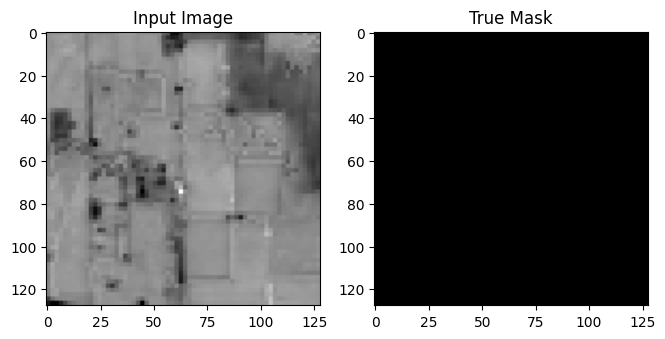

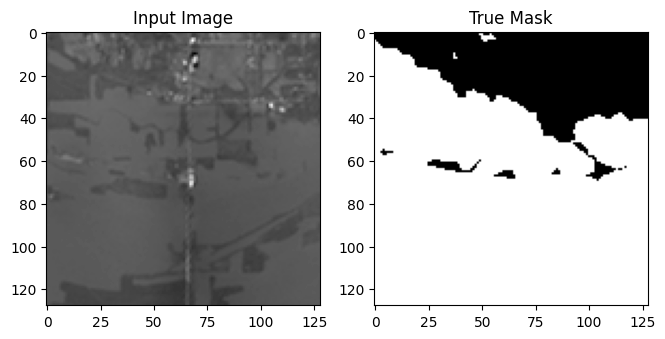

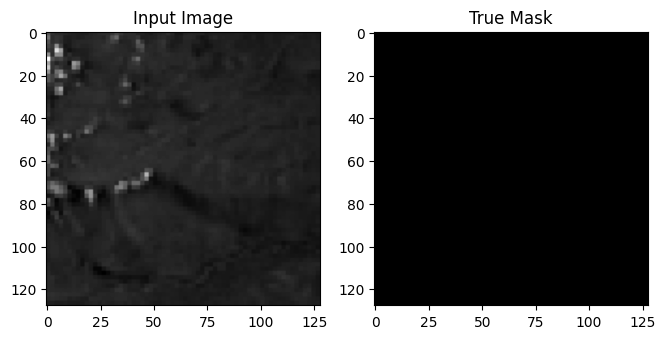

In [8]:
for i in range(3):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.imshow(X_train[i, :, :, 0], cmap='gray')
    plt.title('Input Image')
    plt.subplot(1, 3, 2)
    plt.imshow(y_train[i, :, :, 0], cmap='gray')
    plt.title('True Mask')
    #plt.subplot(1, 3, 3)
    #plt.imshow(preds[i, :, :, 0], cmap='gray')
    #plt.title('Predicted Mask')
    plt.show()


In [9]:
#print(y_train[i, :, :]) #mask values
np.unique(y_train[i+1, :, :])

array([0, 1], dtype=uint8)

In [13]:
# Define callbacks
checkpoint = ModelCheckpoint('unet_model.keras', monitor='val_loss', save_best_only=True)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=30,
    batch_size=8  # Adjust batch size based on your system's memory capacity
    #callbacks=[checkpoint, early_stopping]
)


Epoch 1/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 14s 329ms/step - accuracy: 0.8890 - loss: 0.2925 - val_accuracy: 0.9097 - val_loss: 0.2445
Epoch 2/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 13s 151ms/step - accuracy: 0.8997 - loss: 0.2707 - val_accuracy: 0.9076 - val_loss: 0.2464
Epoch 3/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 4s 152ms/step - accuracy: 0.9024 - loss: 0.2570 - val_accuracy: 0.9082 - val_loss: 0.2483
Epoch 4/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 4s 160ms/step - accuracy: 0.9121 - loss: 0.2426 - val_accuracy: 0.9075 - val_loss: 0.2520
Epoch 5/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 160ms/step - accuracy: 0.9044 - loss: 0.2562 - val_accuracy: 0.9083 - val_loss: 0.2409
Epoch 6/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 4s 161ms/step - accuracy: 0.9034 - loss: 0.2590 - val_accuracy: 0.9108 - val_loss: 0.2341
Epoch 7/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 158ms/step - accuracy: 0.9158 - loss: 0.2337 - val_accuracy: 0.9114 - val_loss: 0.2289
Epoch 8/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 166ms/step - accuracy: 0.8963 - loss: 0.2635 - val_accuracy: 

In [14]:
# Save the model
model.save('unet_model.keras')

3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 330ms/step - accuracy: 0.9093 - loss: 0.3010
Validation Loss: 0.3479
Validation Accuracy: 0.9058
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step


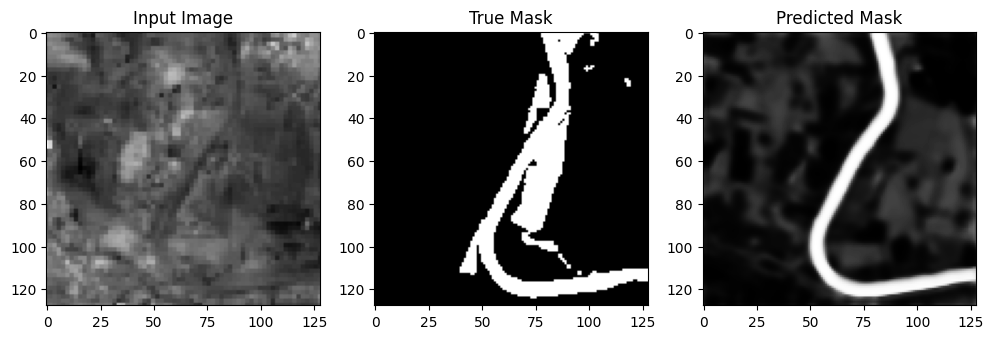

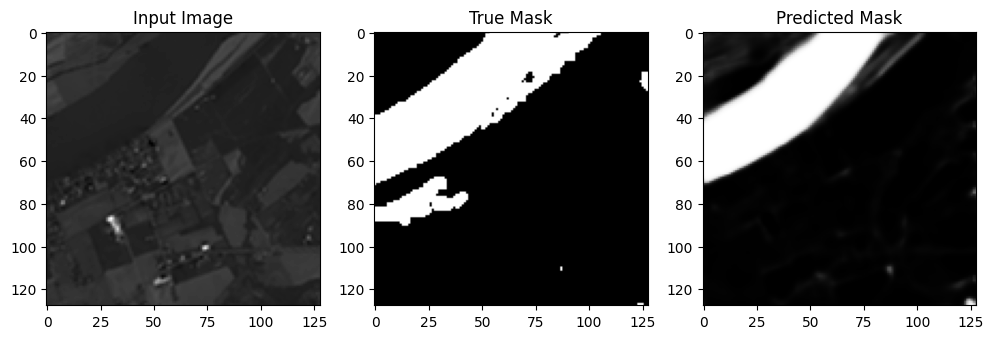

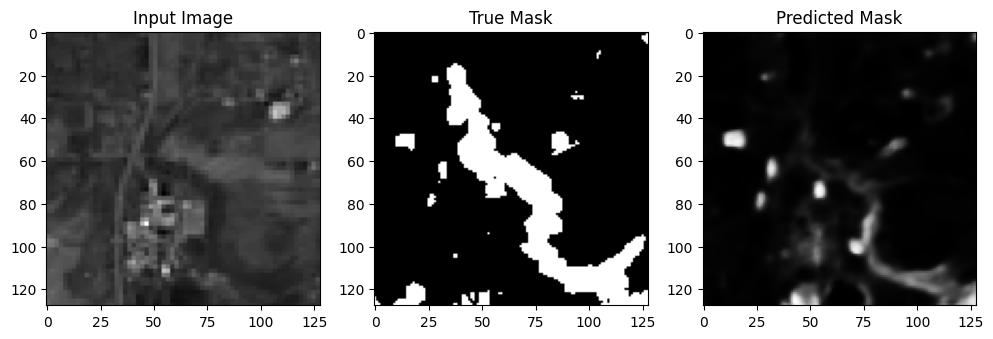

In [15]:
# Load the best model
from tensorflow.keras.models import load_model

model = load_model('unet_model.keras')

# Evaluate on validation set
loss, accuracy = model.evaluate(X_val, y_val)
print(f"Validation Loss: {loss:.4f}")
print(f"Validation Accuracy: {accuracy:.4f}")

# Predict and visualize results
preds = model.predict(X_val)

# Visualize some results
for i in range(3):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.imshow(X_val[i, :, :, 0], cmap='gray')
    plt.title('Input Image')
    plt.subplot(1, 3, 2)
    plt.imshow(y_val[i, :, :, 0], cmap='gray')
    plt.title('True Mask')
    plt.subplot(1, 3, 3)
    plt.imshow(preds[i, :, :, 0], cmap='gray')
    plt.title('Predicted Mask')
    plt.show()
